## Lab 10: Logistic Regression, SVM, PCA

#### Q1) Use logistic regression to predict whether it will rain tomorrow based on today’s weather conditions. Perform necessary data preprocessing such as handling missing values and normalization. Split the dataset into training and testing sets. Train the model and evaluate its performance using accuracy, precision, recall, and F1-score. Finally, plot and interpret the confusion matrix.

   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain

Missing values in each column:
Temperature    0
Humidity       0
Wind_Speed     0
Cloud_Cover    0
Pressure       0
Rain           0
dtype: int64

Model Performance:
Accuracy: 0.9320
Precision: 0.7347
Recall: 0.6316
F1-score: 0.6792


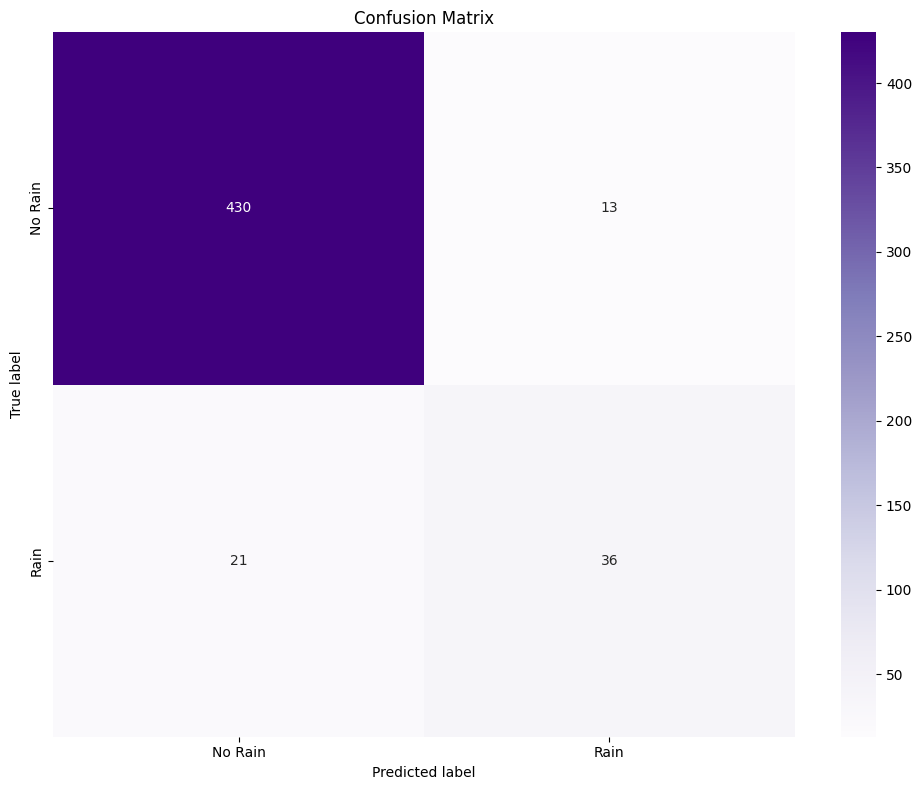


Feature Importance:
       Feature  Coefficient
1     Humidity     2.569458
3  Cloud_Cover     2.308996
2   Wind_Speed     0.019656
4     Pressure    -0.029810
0  Temperature    -1.940104


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Loading dataset
df = pd.read_csv('weather_forecast_data.csv')

# Displaying first few rows to understand the data
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Converting the target variable to binary (0 for 'no rain', 1 for 'rain')
df['Rain'] = df['Rain'].apply(lambda x: 1 if x == 'rain' else 0)

# Split features and target
X = df.drop('Rain', axis=1)
y = df['Rain']

# Spliting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))

# Create the heatmap with seaborn
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.tight_layout()  # layout adjusting to make room for all elements
plt.show()

# Feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)
print("\nFeature Importance:")
print(coefficients)


#### Q2)  In this lab, you will compute normals for each point in a given 3D point cloud using Principal Component Analysis (PCA). You'll explore how PCA can effectively capture local geometric structures and help derive surface normals by analyzing neighboring points.
#### Context: A point cloud is a collection of discrete data points representing the external surface of an object or scene in 3D space. The k-Nearest Neighbors (k-NN) algorithm identifies the closest points to a query point by measuring the distance (usually Euclidean distance) and selecting the nearest points. Normals in point clouds are essential for many geometric processing applications such as rendering, registration, segmentation, and feature detection.
#### Implement the normal computation with PCA using libraries such as NumPy for PCA computation and scipy for finding neighborhoods using KNN. Visualize the resulting point cloud with normals.

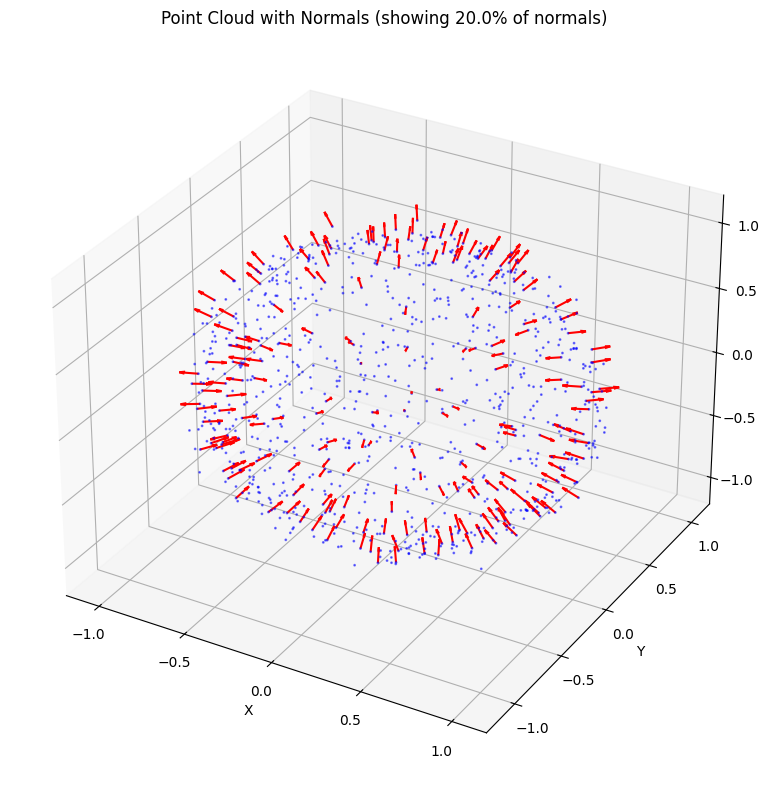

In [16]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_normals_pca(points, k=10):
    """
    Compute normals for each point in a point cloud using PCA.
    
    Parameters:
    points (numpy.ndarray): Point cloud data with shape (n, 3)
    k (int): Number of nearest neighbors to consider
    
    Returns:
    numpy.ndarray: Normal vectors for each point with shape (n, 3)
    """
    # Build KD-tree for efficient nearest neighbor search
    tree = KDTree(points)
    
    # Initialize array to store normals
    normals = np.zeros_like(points)
    
    # Compute normal for each point
    for i, point in enumerate(points):
        # Find k-nearest neighbors
        distances, indices = tree.query(point, k=k+1)  # +1 because the point itself is included
        
        # Get the neighboring points (excluding the query point)
        neighbors = points[indices[1:]]
        
        # Center the neighborhood
        centered_neighbors = neighbors - point
        
        # Compute the covariance matrix
        cov_matrix = np.cov(centered_neighbors, rowvar=False)
        
        # Perform eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # The eigenvector corresponding to the smallest eigenvalue
        # is the normal vector (direction of least variance)
        normal = eigenvectors[:, 0]
        
        # Ensure consistent orientation (optional)
        # This is a simple heuristic - in practice, more sophisticated
        # methods might be needed for consistent orientation
        if normal[2] < 0:  # Assuming z is "up"
            normal = -normal
            
        # Store the normal
        normals[i] = normal
    
    return normals

def visualize_point_cloud_with_normals(points, normals, sample_ratio=0.1):
    """
    Visualize the point cloud with normal vectors.
    
    Parameters:
    points (numpy.ndarray): Point cloud data with shape (n, 3)
    normals (numpy.ndarray): Normal vectors with shape (n, 3)
    sample_ratio (float): Ratio of points to display normals for (to avoid clutter)
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Ploting all points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', s=1, alpha=0.5)
    
    # Sample a subset of points to show normals
    n_points = points.shape[0]
    sample_size = int(n_points * sample_ratio)
    sample_indices = np.random.choice(n_points, sample_size, replace=False)
    
    # Scaling factor for normal visualization
    scale = 0.1
    
    # Ploting normals as arrows
    for i in sample_indices:
        ax.quiver(
            points[i, 0], points[i, 1], points[i, 2],
            normals[i, 0], normals[i, 1], normals[i, 2],
            color='r', length=scale, normalize=True
        )
    
    # Setting aspect ratio which is will be eqaul for all axis
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Point Cloud with Normals (showing {sample_ratio*100:.1f}% of normals)')
    
    plt.tight_layout()
    plt.show()
    
def generate_sphere_point_cloud(n_points=1000, radius=1.0, noise=0.05):
    """Generate a noisy sphere point cloud."""
    # Generating random points on a unit sphere
    phi = np.random.uniform(0, 2*np.pi, n_points)
    costheta = np.random.uniform(-1, 1, n_points)
    theta = np.arccos(costheta)
    
    # Converting to Cartesian coordinates
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    
    # Adding noise
    x += np.random.normal(0, noise, n_points)
    y += np.random.normal(0, noise, n_points)
    z += np.random.normal(0, noise, n_points)
    
    return np.column_stack((x, y, z))

# Generatign a sample point cloud
points = generate_sphere_point_cloud(n_points=1000)

# Computing normals
normals = compute_normals_pca(points, k=20)

# Visualization
visualize_point_cloud_with_normals(points, normals, sample_ratio=0.2)


#### Q3) 3. Create  geometric shapes like circle, ellipse, rectangle, square, star. Extract features from them(features may be your choice) and use SVM for shape classification.

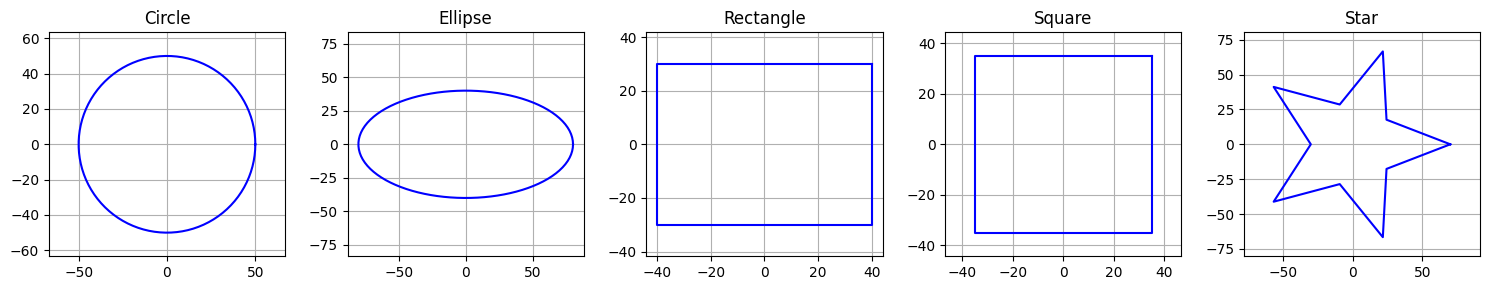

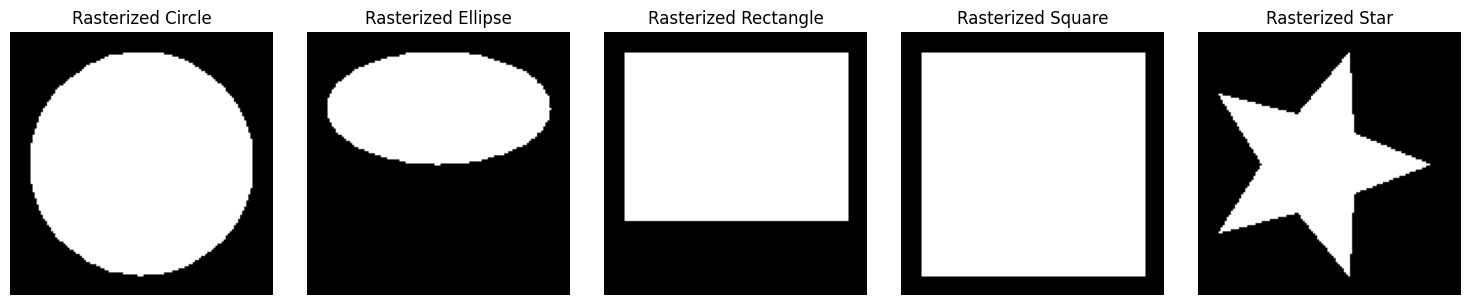

Generating dataset...
Dataset shape: (1000, 7)
Number of samples per class: [200 200 200 200 200]
Training SVM classifier...
Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        33
     ellipse       1.00      1.00      1.00        48
   rectangle       1.00      0.78      0.88        37
      square       0.83      1.00      0.90        38
        star       1.00      1.00      1.00        44

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200

Confusion Matrix:
[[33  0  0  0  0]
 [ 0 48  0  0  0]
 [ 0  0 29  8  0]
 [ 0  0  0 38  0]
 [ 0  0  0  0 44]]

Testing with a new shape...
Predicted shape: star


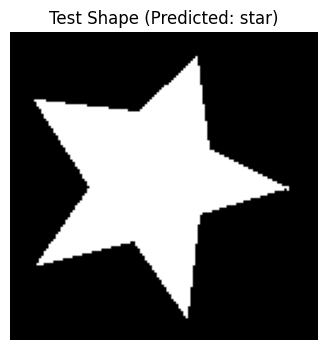

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import math

# Setting random seed for reproducibility
np.random.seed(42)

def create_circle(radius=None, noise_level=0.0):
    """Create a circle with the given radius"""
    if radius is None:
        radius = np.random.randint(30, 100)
    
    # Generating points along the circle
    theta = np.linspace(0, 2*np.pi, 100)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    
    # Adding noise
    if noise_level > 0:
        x += np.random.normal(0, noise_level, size=x.shape)
        y += np.random.normal(0, noise_level, size=y.shape)
    
    return np.column_stack((x, y)), radius

def create_ellipse(a=None, b=None, noise_level=0.0):
    """Create an ellipse with semi-major axis a and semi-minor axis b"""
    if a is None:
        a = np.random.randint(50, 120)
    if b is None:
        b = np.random.randint(20, 50)
    
    # Ensure a > b
    if b > a:
        a, b = b, a
    
    # Generating points along the ellipse
    theta = np.linspace(0, 2*np.pi, 100)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    
    # Adding noise 
    if noise_level > 0:
        x += np.random.normal(0, noise_level, size=x.shape)
        y += np.random.normal(0, noise_level, size=y.shape)
    
    return np.column_stack((x, y)), (a, b)

def create_rectangle(width=None, height=None, noise_level=0.0):
    """Create a rectangle with the given width and height"""
    if width is None:
        width = np.random.randint(40, 120)
    if height is None:
        height = np.random.randint(40, 120)
    
    # Define the four corners of the rectangle
    x = np.array([width/2, width/2, -width/2, -width/2, width/2])
    y = np.array([height/2, -height/2, -height/2, height/2, height/2])
    
    # Adding noise
    if noise_level > 0:
        x += np.random.normal(0, noise_level, size=x.shape)
        y += np.random.normal(0, noise_level, size=y.shape)
    
    return np.column_stack((x, y)), (width, height)

def create_square(side=None, noise_level=0.0):
    """Create a square with the given side length"""
    if side is None:
        side = np.random.randint(40, 120)
    
    return create_rectangle(side, side, noise_level)

def create_star(outer_radius=None, inner_radius=None, points=5, noise_level=0.0):
    """Create a star with the given outer and inner radii and number of points"""
    if outer_radius is None:
        outer_radius = np.random.randint(60, 120)
    if inner_radius is None:
        inner_radius = outer_radius * np.random.uniform(0.3, 0.5)
    
    # Generating points for the star
    theta = np.linspace(0, 2*np.pi, 2*points, endpoint=False)
    radii = np.array([outer_radius, inner_radius] * points)
    
    x = radii * np.cos(theta)
    y = radii * np.sin(theta)
    
    # Adding closing point
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    
    # Adding noise 
    if noise_level > 0:
        x += np.random.normal(0, noise_level, size=x.shape)
        y += np.random.normal(0, noise_level, size=y.shape)
    
    return np.column_stack((x, y)), (outer_radius, inner_radius)

def plot_shape(points, shape_type):
    """Plot a shape given its points and type"""
    plt.figure(figsize=(4, 4))
    plt.plot(points[:, 0], points[:, 1], 'b-')
    plt.title(shape_type)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def rasterize_shape(points, size=128):
    """Convert shape points to a binary image"""
    # Scaling points to fit within the image
    points = points.copy()
    min_vals = np.min(points, axis=0)
    max_vals = np.max(points, axis=0)
    
    # Scaling and translate to fit in the image with some padding
    padding = 10
    scale = min((size - 2*padding) / (max_vals[0] - min_vals[0]), 
                (size - 2*padding) / (max_vals[1] - min_vals[1]))
    
    points = (points - min_vals) * scale
    points = points + padding
    
    # Creating a blank image
    img = np.zeros((size, size), dtype=np.uint8)
    
    # Converting points to integer coordinates for drawing
    points = points.astype(np.int32)
    
    # Drawing the shape
    cv2.polylines(img, [points], True, 255, 1)
    cv2.fillPoly(img, [points], 255)
    
    return img

def extract_features(img):
    """Extract features from a binary image of a shape"""
    # Finding contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return np.zeros(7)  # Returning zeros if no contours found
    
    # Taking the largest contour
    contour = max(contours, key=cv2.contourArea)
    
    # Calculating area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Calculating circularity: 4*pi*area/perimeter^2
    # A perfect circle has circularity = 1
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    
    # Calculating bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Calculating minimum enclosing circle
    (center_x, center_y), radius = cv2.minEnclosingCircle(contour)
    circle_area = np.pi * radius ** 2
    
    # Calculating convex hull
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0
    
    # Calculate moments and Hu moments
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Returning a feature vector
    features = np.array([
        area,
        perimeter,
        circularity,
        aspect_ratio,
        float(area) / circle_area if circle_area > 0 else 0,  # Area ratio to enclosing circle
        solidity,
        hu_moments[0]  # First Hu moment
    ])
    
    return features

def generate_dataset(n_samples_per_class=100, noise_level=2.0):
    """Generate a dataset of shapes with features"""
    shapes = []
    labels = []
    
    # Generating circles
    for _ in range(n_samples_per_class):
        points, _ = create_circle(noise_level=noise_level)
        img = rasterize_shape(points)
        features = extract_features(img)
        shapes.append(features)
        labels.append('circle')
    
    # Generating ellipses
    for _ in range(n_samples_per_class):
        points, _ = create_ellipse(noise_level=noise_level)
        img = rasterize_shape(points)
        features = extract_features(img)
        shapes.append(features)
        labels.append('ellipse')
    
    # Generating rectangles
    for _ in range(n_samples_per_class):
        points, _ = create_rectangle(noise_level=noise_level)
        img = rasterize_shape(points)
        features = extract_features(img)
        shapes.append(features)
        labels.append('rectangle')
    
    # Generate squares
    for _ in range(n_samples_per_class):
        points, _ = create_square(noise_level=noise_level)
        img = rasterize_shape(points)
        features = extract_features(img)
        shapes.append(features)
        labels.append('square')
    
    # Generating stars
    for _ in range(n_samples_per_class):
        points, _ = create_star(noise_level=noise_level)
        img = rasterize_shape(points)
        features = extract_features(img)
        shapes.append(features)
        labels.append('star')
    
    return np.array(shapes), np.array(labels)

def train_svm_classifier(X, y):
    """Train an SVM classifier on the shape features"""
    # Spliting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardizing features as per class notes
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Training SVM classifier
    clf = svm.SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train_scaled, y_train)
    
    # Evaluating the classifier
    y_pred = clf.predict(X_test_scaled)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return clf, scaler

def visualize_sample_shapes():
    """Visualize one sample of each shape type"""
    # Creating and plot one of each shape
    shapes = [
        ('Circle', create_circle(radius=50)[0]),
        ('Ellipse', create_ellipse(a=80, b=40)[0]),
        ('Rectangle', create_rectangle(width=80, height=60)[0]),
        ('Square', create_square(side=70)[0]),
        ('Star', create_star(outer_radius=70, inner_radius=30)[0])
    ]
    
    plt.figure(figsize=(15, 3))
    for i, (name, points) in enumerate(shapes):
        plt.subplot(1, 5, i+1)
        plt.plot(points[:, 0], points[:, 1], 'b-')
        plt.title(name)
        plt.axis('equal')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Also showing the rasterized versions
    plt.figure(figsize=(15, 3))
    for i, (name, points) in enumerate(shapes):
        plt.subplot(1, 5, i+1)
        img = rasterize_shape(points)
        plt.imshow(img, cmap='gray')
        plt.title(f"Rasterized {name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    # Visualization of sample shapes
    visualize_sample_shapes()
    
    # Generating dataset
    print("Generating dataset...")
    X, y = generate_dataset(n_samples_per_class=200, noise_level=2.0)
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of samples per class: {np.bincount(np.unique(y, return_inverse=True)[1])}")
    
    # Training classifier
    print("Training SVM classifier...")
    clf, scaler = train_svm_classifier(X, y)
    
    # Testing with a new shape
    print("\nTesting with a new shape...")
    test_points, _ = create_star(outer_radius=80, inner_radius=35, noise_level=3.0)
    test_img = rasterize_shape(test_points)
    test_features = extract_features(test_img)
    
    # Scaling the features
    test_features_scaled = scaler.transform([test_features])
    
    # Predict
    prediction = clf.predict(test_features_scaled)[0]
    print(f"Predicted shape: {prediction}")
    
    # Visualization the test shape
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img, cmap='gray')
    plt.title(f"Test Shape (Predicted: {prediction})")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()
